# Welcome to predicting!!

## If in collab

Mount in drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Allow access to gcloud

In [2]:
from google.colab import auth
auth.authenticate_user()

## Packages

In [3]:
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install -q monai
!pip install datasets

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ncs8qzwa
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ncs8qzwa
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from scipy import ndimage
from PIL import Image
from google.cloud import storage
from transformers import SamModel, SamConfig, SamProcessor
import torch
from io import BytesIO

## Load the model

In [5]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
solar_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
solar_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab_Notebooks/final_project/model_checkpoint/fully_trained.pth"))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


<All keys matched successfully>

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
solar_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

## Data leakage vers

In [7]:
client = storage.Client()  # Implicit environ set-up
training_bucket = client.get_bucket('training_images_solar')

#get all file names
# file_names = [blob.name for blob in training_bucket.list_blobs(prefix='original')]
# #sort file names
# file_names_sorted = sorted(file_names)

originals = []
for i in range(2000, 2050):
  blob = training_bucket.blob(f'original/{i}.png')
  as_bytes = blob.download_as_bytes()
  im = Image.open(BytesIO(as_bytes))
  #resize w pillow!!
  im = im.resize((256, 256))
  # #append to list as an array
  originals.append(np.asarray(im, dtype=np.uint8))

masks = []
for i in range(2000, 2050):
  blob = training_bucket.blob(f'renamed_gray/{i}.png')
  as_bytes = blob.download_as_bytes()
  im = Image.open(BytesIO(as_bytes))
  #resize w pillow!!
  im = im.resize((256, 256))
  # #append to list as an array
  masks.append(np.asarray(im, dtype=np.uint8))

In [8]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [12]:
# Create a list to store the indices of non-empty masks

originals_np = np.array(originals)
masks_np = np.array(masks)

valid_indices = [i for i, mask in enumerate(masks_np) if mask.max() != 0]

# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = originals_np[valid_indices]
filtered_masks = masks_np[valid_indices]

print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (29, 256, 256, 3)
Mask shape: (29, 256, 256)


In [13]:
from datasets import Dataset

dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 29
})

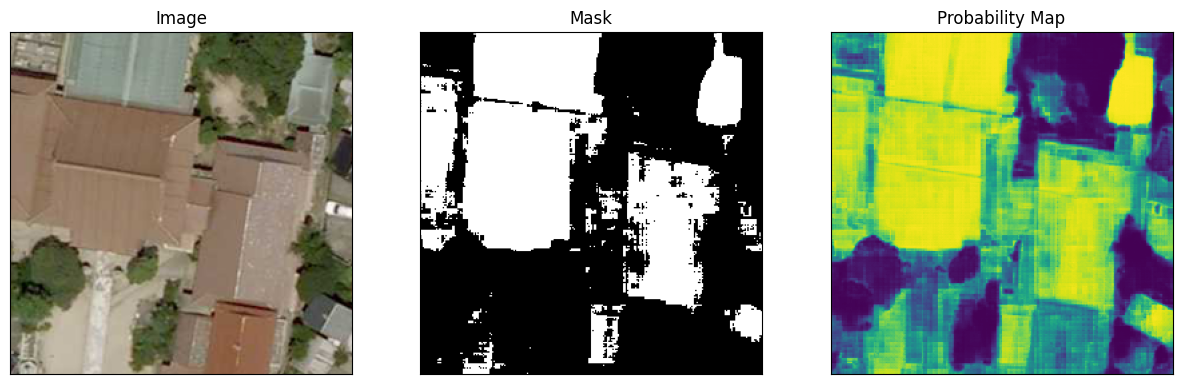

In [15]:
# let's take a random training example
idx = random.randint(0, originals_np.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

solar_model.eval()

# forward pass
with torch.no_grad():
    outputs = solar_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.8).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## Google maps data

In [16]:
training_bucket = client.get_bucket('training_images_solar')

def import_data(folder, bucket) -> np.array:
    """
    Import images from specified Google Cloud folder
    Returns a list of arrays
    """

    #get all file names
    file_names = [blob.name for blob in bucket.list_blobs(prefix=folder)]

    #storing all the np.array images
    folder_images = []

    i = 1
    for file in file_names:
        #import each picture from folder
        blob = bucket.blob(file)
        as_bytes = blob.download_as_bytes()
        im = Image.open(BytesIO(as_bytes))
        # #append to list as an array
        folder_images.append(np.asarray(im, dtype=np.uint8))

        #just a counter to see how fast it's moving
        print(f"Completed {i} images")
        i+=1

    return folder_images

In [17]:
test = import_data(folder='google_images', bucket=training_bucket)

Completed 1 images
Completed 2 images
Completed 3 images
Completed 4 images
Completed 5 images
Completed 6 images
Completed 7 images
Completed 8 images
Completed 9 images
Completed 10 images
Completed 11 images
Completed 12 images
Completed 13 images
Completed 14 images
Completed 15 images
Completed 16 images
Completed 17 images
Completed 18 images
Completed 19 images
Completed 20 images
Completed 21 images
Completed 22 images
Completed 23 images
Completed 24 images
Completed 25 images
Completed 26 images
Completed 27 images
Completed 28 images
Completed 29 images
Completed 30 images
Completed 31 images
Completed 32 images
Completed 33 images
Completed 34 images
Completed 35 images
Completed 36 images
Completed 37 images
Completed 38 images
Completed 39 images
Completed 40 images
Completed 41 images
Completed 42 images
Completed 43 images
Completed 44 images
Completed 45 images
Completed 46 images
Completed 47 images
Completed 48 images
Completed 49 images
Completed 50 images
Completed

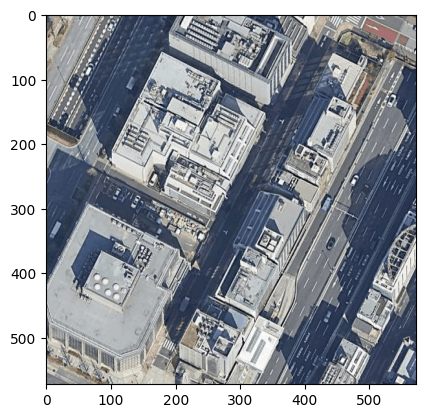

In [18]:
img = test[50]
plt.imshow(img)

In [19]:
#slice one of the channels off
img = img[:,:,1:]

# Define the size of your array
array_size = img.shape[0]
# Define the size of your grid
grid_size = 5

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [20]:
print(np.array(input_points).shape)

(1, 1, 25, 2)


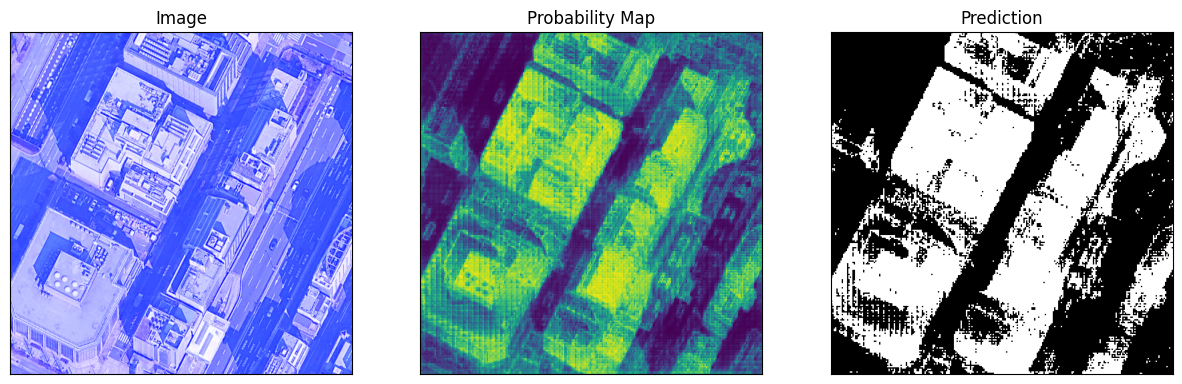

In [21]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
# i, j = 1, 2

# # Selected patch for segmentation
# random_array = patches[i, j]


single_img = Image.fromarray(img)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
# inputs = processor(single_img, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_img, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
solar_model.eval()


# forward pass
with torch.no_grad():
  outputs = solar_model(**inputs, multimask_output=False)

# apply sigmoid
img_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
img_prob = img_prob.cpu().numpy().squeeze()
img_prediction = (img_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(img), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(img_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(img_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()